In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
import rioxarray as rxr
import rasterio
import adlfs
import contextily as ctx
from tqdm import tqdm

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(processes=False, n_workers=4, local_directory='/tmp')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/egagli@uw.edu/proxy/8787/status,
Dashboard: /user/egagli@uw.edu/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: False
Comm: inproc://10.244.87.19/704/1,Workers: 4
Dashboard: /user/egagli@uw.edu/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: inproc://10.244.87.19/704/7,Total threads: 1
Dashboard: /user/egagli@uw.edu/proxy/41633/status,Memory: 8.00 GiB
Nanny: None,


In [3]:
gf = gpd.read_file('https://github.com/scottyhq/snotel/raw/main/snotel-sites.geojson')

In [15]:
snotel_gf = gf[gf.isActive==True]
#snotel_gf = snotel_gf[snotel_gf.state!='Alaska']

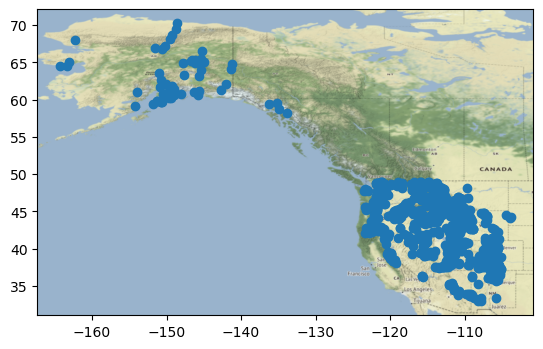

In [16]:
f,ax=plt.subplots()
snotel_gf.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=snotel_gf.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [17]:
snotel_gf

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,HUC,isActive,geometry
0,301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,180200021403,True,POINT (-120.79192 41.23583)
1,907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,160300020301,True,POINT (-112.27118 37.52217)
2,916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,100200050701,True,POINT (-111.95902 45.59723)
3,1267_AK_SNTL,Alexander Lake,48.768002,61.749668,-150.889664,Matanuska-Susitna,Alaska,2014-08-28 00:00:00,2100-01-01,190205051106,True,POINT (-150.88966 61.74967)
4,908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,171100100501,True,POINT (-121.69847 47.77957)
...,...,...,...,...,...,...,...,...,...,...,...,...
925,877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,150601030802,True,POINT (-110.91773 33.81242)
926,1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,140600090303,True,POINT (-111.35685 39.13233)
927,1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,160300060202,True,POINT (-112.77495 37.74797)
928,878_WY_SNTL,Younts Peak,2545.080078,43.932251,-109.817749,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,100800130103,True,POINT (-109.81775 43.93225)


In [18]:
# Really need to convert this to water year...DOWY
for i,row in tqdm(snotel_gf.iterrows()):
    try:
        snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{row.code}.parquet').loc[slice(f'2014-01-01',f'2022-12-31')]
        dates = snotel_data.groupby(snotel_data.index.year).idxmax()['WTEQ']
        for year in [date for date in dates.index]:
            snotel_gf.loc[i,f'max_swe_{year}'] = dates.dt.dayofyear[year]
    except:
        pass

0it [00:00, ?it/s]/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [19]:
snotel_gf

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,HUC,...,geometry,max_swe_2014,max_swe_2015,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022
0,301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,180200021403,...,POINT (-120.79192 41.23583),95.0,362.0,51.0,68.0,86.0,75.0,32.0,74.0,76.0
1,907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,160300020301,...,POINT (-112.27118 37.52217),38.0,64.0,33.0,65.0,78.0,81.0,88.0,76.0,71.0
2,916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,100200050701,...,POINT (-111.95902 45.59723),135.0,107.0,97.0,122.0,107.0,121.0,114.0,117.0,154.0
3,1267_AK_SNTL,Alexander Lake,48.768002,61.749668,-150.889664,Matanuska-Susitna,Alaska,2014-08-28 00:00:00,2100-01-01,190205051106,...,POINT (-150.88966 61.74967),365.0,364.0,89.0,89.0,96.0,365.0,104.0,103.0,96.0
4,908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,171100100501,...,POINT (-121.69847 47.77957),96.0,362.0,96.0,109.0,108.0,83.0,102.0,107.0,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,150601030802,...,POINT (-110.91773 33.81242),1.0,18.0,40.0,25.0,51.0,54.0,1.0,30.0,2.0
926,1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,140600090303,...,POINT (-111.35685 39.13233),95.0,63.0,89.0,66.0,82.0,89.0,90.0,83.0,76.0
927,1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,160300060202,...,POINT (-112.77495 37.74797),97.0,63.0,91.0,94.0,64.0,81.0,88.0,86.0,80.0
928,878_WY_SNTL,Younts Peak,2545.080078,43.932251,-109.817749,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,100800130103,...,POINT (-109.81775 43.93225),NaN,358.0,89.0,76.0,105.0,106.0,108.0,92.0,119.0


In [20]:
snotel_gf['median_doy_max_swe'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('max_swe')]].median(axis=1)
snotel_gf['mean_doy_max_swe'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('max_swe')]].mean(axis=1)
snotel_gf['std_doy_max_swe'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('max_swe')]].std(axis=1)

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [21]:
snotel_gf

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,HUC,...,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022,median_doy_max_swe,mean_doy_max_swe,std_doy_max_swe
0,301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,180200021403,...,51.0,68.0,86.0,75.0,32.0,74.0,76.0,75.0,102.111111,99.216234
1,907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,160300020301,...,33.0,65.0,78.0,81.0,88.0,76.0,71.0,71.0,66.000000,18.894444
2,916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,100200050701,...,97.0,122.0,107.0,121.0,114.0,117.0,154.0,117.0,119.333333,16.933694
3,1267_AK_SNTL,Alexander Lake,48.768002,61.749668,-150.889664,Matanuska-Susitna,Alaska,2014-08-28 00:00:00,2100-01-01,190205051106,...,89.0,89.0,96.0,365.0,104.0,103.0,96.0,103.0,185.666667,134.348428
4,908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,171100100501,...,96.0,109.0,108.0,83.0,102.0,107.0,116.0,107.0,131.000000,87.156468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,150601030802,...,40.0,25.0,51.0,54.0,1.0,30.0,2.0,25.0,24.666667,20.904545
926,1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,140600090303,...,89.0,66.0,82.0,89.0,90.0,83.0,76.0,83.0,81.444444,11.080513
927,1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,160300060202,...,91.0,94.0,64.0,81.0,88.0,86.0,80.0,86.0,82.666667,12.186058
928,878_WY_SNTL,Younts Peak,2545.080078,43.932251,-109.817749,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,100800130103,...,89.0,76.0,105.0,106.0,108.0,92.0,119.0,105.5,131.625000,92.435209


In [22]:
snotel_doy_max_swe_gf = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('max_swe')]]

In [23]:
start_year = int(snotel_doy_max_swe_gf.columns[0][8:])
end_year = int(snotel_doy_max_swe_gf.columns[-1][8:])
years = list(range(start_year,end_year+1))

In [55]:
for i,row in snotel_gf.iterrows():
    try:
        idx = np.isfinite(snotel_doy_max_swe_gf.loc[i])
        snotel_gf.loc[i,f'trend'] =  np.polyfit(np.array(years)[idx.values], snotel_doy_max_swe_gf.loc[i][idx], 1)[0]
    except:
        pass

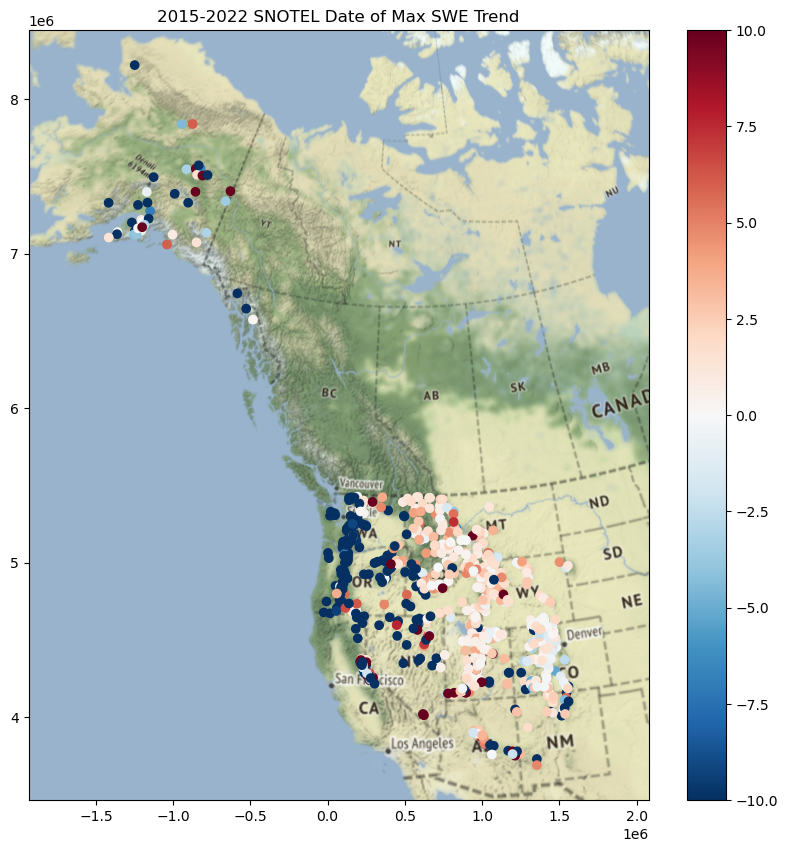

In [28]:
f,ax=plt.subplots(figsize=(10,10))
snotel_gf_projected = gpd.GeoDataFrame(snotel_gf,geometry=gf.geometry).to_crs('EPSG:32611')
snotel_gf_projected.plot(column='trend',ax=ax,legend=True,cmap='RdBu_r',vmin=-10,vmax=10)
ax.axis('equal')
ax.set_title('2015-2022 SNOTEL Date of Max SWE Trend')
ctx.add_basemap(ax=ax, crs=snotel_gf_projected.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [29]:
tooltip_list = ['code','name','elevation_m','mean_doy_max_swe','median_doy_max_swe','std_doy_max_swe','trend']

In [31]:
snotel_gf_projected.drop(['beginDate','endDate','isActive'],axis=1).explore(column='trend',cmap='RdBu_r',tooltip=tooltip_list,vmin=-10,vmax=10)

In [32]:
snotel_gf_projected.corr()

,elevation_m,latitude,longitude,isActive,max_swe_2014,max_swe_2015,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022,median_doy_max_swe,mean_doy_max_swe,std_doy_max_swe,trend
elevation_m,1.000000,-0.791792,0.829118,NaN,0.065791,-0.430349,0.060969,-0.039201,0.093578,0.053953,0.029486,-0.084106,0.048724,0.147266,-0.214331,-0.427221,0.299550
latitude,-0.791792,1.000000,-0.847944,NaN,0.121990,0.134965,0.127138,0.417329,-0.149637,0.223523,0.326738,0.101090,0.118153,0.339458,0.340495,0.077808,-0.165928
longitude,0.829118,-0.847944,1.000000,NaN,-0.004969,-0.414138,0.031503,-0.234621,0.072092,-0.146641,-0.157005,-0.206980,-0.005075,-0.050600,-0.396522,-0.413138,0.294361
isActive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_swe_2014,0.065791,0.121990,-0.004969,NaN,1.000000,-0.077575,0.063840,0.202029,0.019098,0.213826,0.155899,-0.003818,0.141588,0.310542,0.368387,-0.008990,-0.273126
max_swe_2015,-0.430349,0.134965,-0.414138,NaN,-0.077575,1.000000,-0.138663,-0.099271,0.000711,-0.173721,-0.159496,0.082198,-0.006678,-0.176708,0.543614,0.738904,-0.700196
max_swe_2016,0.060969,0.127138,0.031503,NaN,0.063840,-0.138663,1.000000,0.223501,-0.152154,0.108623,0.258978,-0.019269,0.062876,0.402099,0.232844,-0.145044,-0.119697
max_swe_2017,-0.039201,0.417329,-0.234621,NaN,0.202029,-0.099271,0.223501,1.000000,-0.136319,0.305352,0.403634,0.076809,0.211500,0.659401,0.380484,-0.213880,0.060203
max_swe_2018,0.093578,-0.149637,0.072092,NaN,0.019098,0.000711,-0.152154,-0.136319,1.000000,0.090518,-0.197355,0.050720,-0.028142,-0.203905,0.302800,0.388705,-0.055088
max_swe_2019,0.053953,0.223523,-0.146641,NaN,0.213826,-0.173721,0.108623,0.305352,0.090518,1.000000,0.168450,0.050538,0.069207,0.364931,0.353895,-0.034336,-0.115045


Text(0.5, 1.0, 'SNOTEL Date of Max SWE Trend vs Elevation')

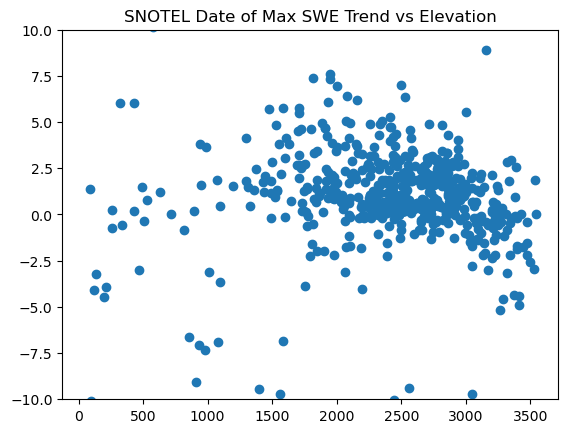

In [33]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['elevation_m'],snotel_gf_projected['trend'])
ax.set_ylim([-10,10])
ax.set_title('SNOTEL Date of Max SWE Trend vs Elevation')

Text(0.5, 1.0, 'SNOTEL Date of Max SWE Trend vs Latitude')

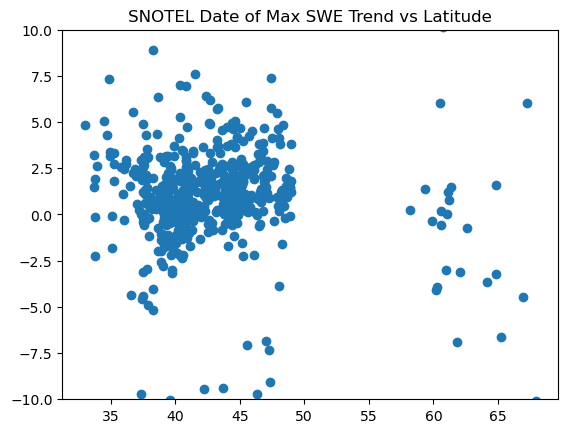

In [34]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['latitude'],snotel_gf_projected['trend'])
ax.set_ylim([-10,10])
ax.set_title('SNOTEL Date of Max SWE Trend vs Latitude')

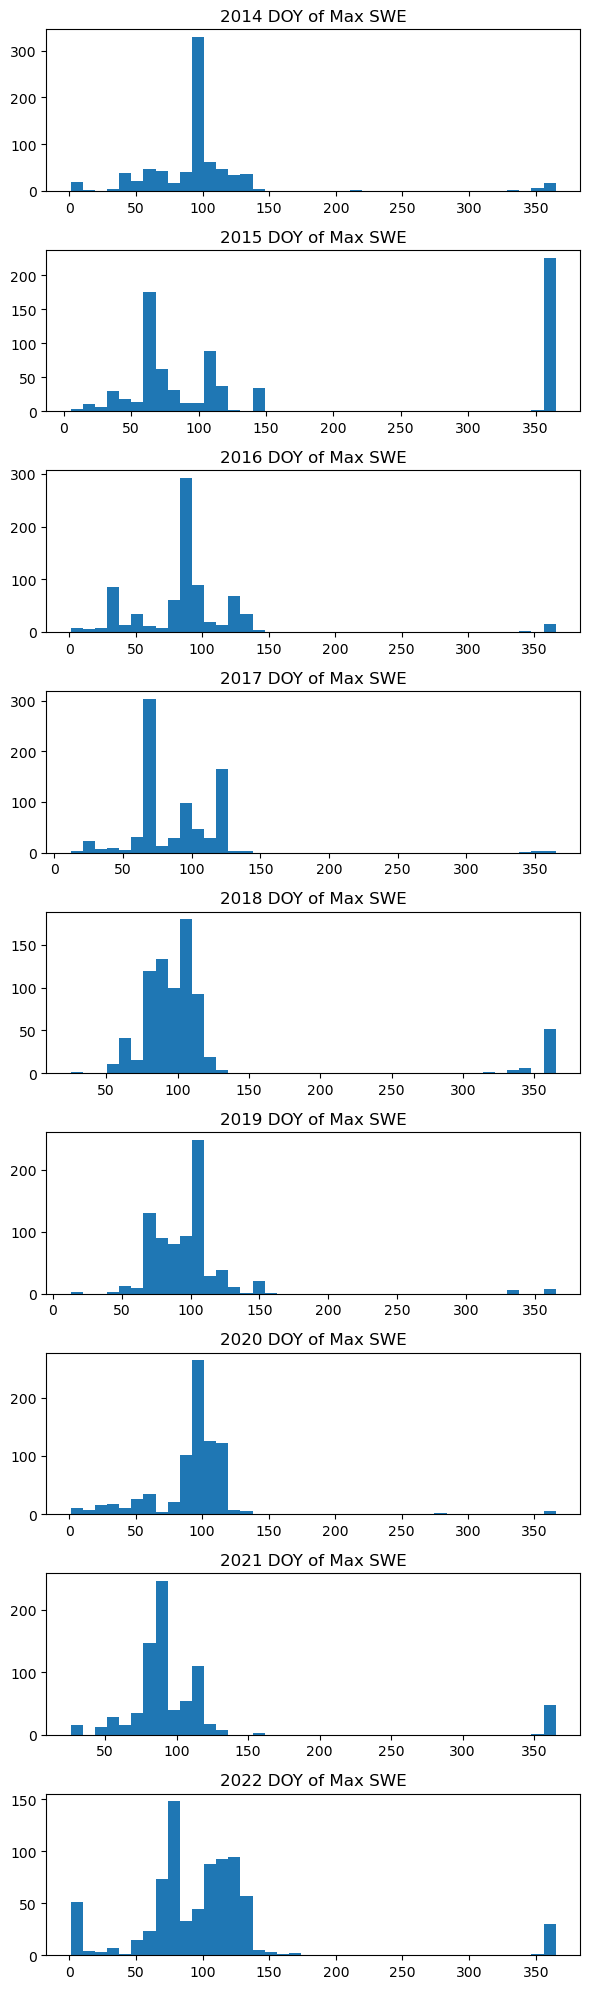

In [50]:
f,ax=plt.subplots(len(years),1,figsize=(6,20))
for year,axs in zip(years,ax.ravel()):
    axs.hist(snotel_gf_projected[f'max_swe_{year}'],bins=40)
    axs.set_title(f'{year} DOY of Max SWE')
plt.tight_layout()

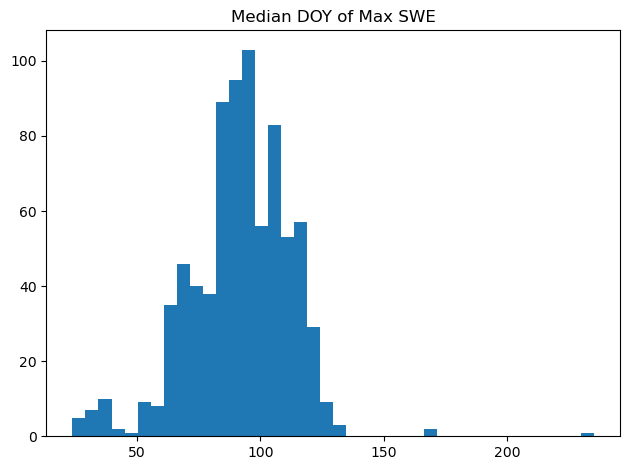

In [52]:
f,ax=plt.subplots()
ax.hist(snotel_gf_projected[f'median_doy_max_swe'],bins=40)
ax.set_title(f'Entire Time Series Median DOY of Max SWE')
plt.tight_layout()

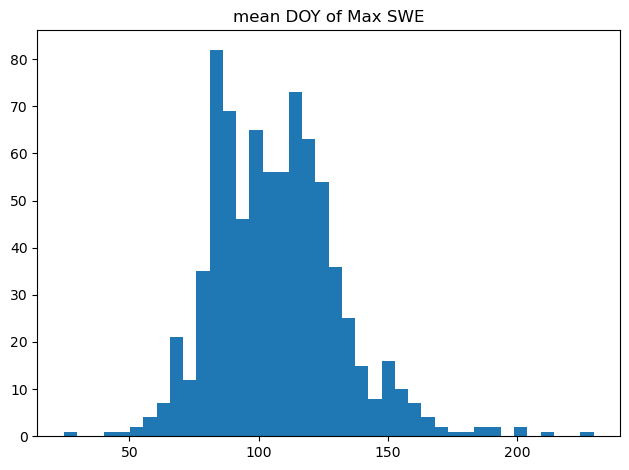

In [53]:
f,ax=plt.subplots()
ax.hist(snotel_gf_projected[f'mean_doy_max_swe'],bins=40)
ax.set_title(f'Entire Time Series Mean DOY of Max SWE')
plt.tight_layout()

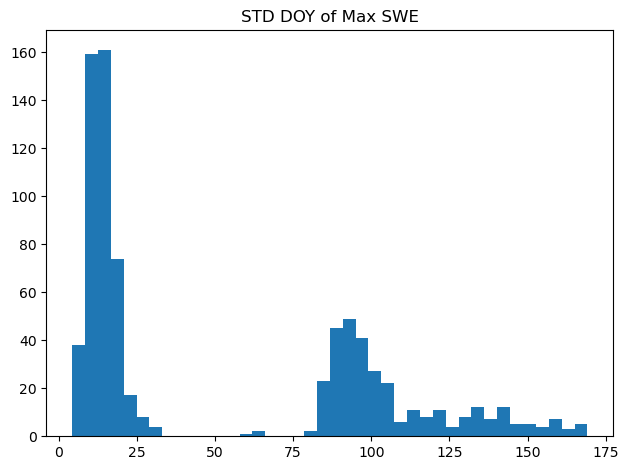

In [54]:
f,ax=plt.subplots()
ax.hist(snotel_gf_projected[f'std_doy_max_swe'],bins=40)
ax.set_title(f'Entire Time Series STD DOY of Max SWE')
plt.tight_layout()

In [35]:
snotel_gf_projected.describe()

,elevation_m,latitude,longitude,max_swe_2014,max_swe_2015,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022,median_doy_max_swe,mean_doy_max_swe,std_doy_max_swe,trend
count,868.000000,868.000000,868.000000,763.000000,769.000000,772.000000,774.000000,776.000000,779.000000,780.000000,779.000000,778.000000,781.000000,781.000000,781.000000,781.000000
mean,2173.990565,43.661984,-115.685892,98.230668,163.368010,90.046632,88.394057,115.885309,99.213094,93.788462,107.781772,101.497429,91.790653,106.930128,52.263188,-3.054932
std,779.290799,6.391633,10.438505,53.187671,131.882834,49.793560,36.811551,73.397836,39.274831,34.455085,69.116634,63.103014,20.606447,24.417993,48.360580,10.684776
min,7.620000,32.924011,-164.292572,1.000000,5.000000,1.000000,12.000000,25.000000,13.000000,1.000000,26.000000,1.000000,24.000000,24.666667,4.272002,-80.700000
25%,1699.260040,39.591045,-119.563408,83.500000,64.000000,76.000000,67.000000,85.000000,78.500000,90.000000,85.000000,75.250000,82.000000,88.888889,12.509996,-10.650000
50%,2345.283569,42.619249,-112.735241,96.000000,104.000000,90.000000,74.000000,100.000000,96.000000,97.000000,88.000000,97.000000,93.000000,105.555556,18.220867,0.416667
75%,2750.057922,45.747646,-109.672152,105.000000,359.000000,96.000000,112.750000,109.000000,107.000000,108.000000,108.000000,119.000000,107.000000,121.222222,95.388679,1.950000
max,3541.775879,70.266663,-103.787582,365.000000,365.000000,366.000000,365.000000,365.000000,365.000000,366.000000,365.000000,365.000000,235.000000,229.500000,169.134398,24.083333
